In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn
import torch.optim as optim

from copy import deepcopy

import sys
sys.path.insert(0, '../../rb_utils/')
import optimization_lib as optim_lib
import baselines_lib as bs_lib

from torch.distributions import negative_binomial, binomial

In [2]:
np.random.seed(34345)
_ = torch.random.manual_seed(43453)

# Draw data

Our model is a Poisson-Binomial mixture, with a Negative Binomial as our variational distribution. 

Our generative model: 

\begin{align}
K &\sim \text{Poisson}(\lambda)\\
y_i &\sim \text{Binomial}(K, p) \quad \text{for} \quad i = 1, ..., N
\end{align}

We will take $p$ as fixed. We infer $K$, which takes values on the positive integers. 

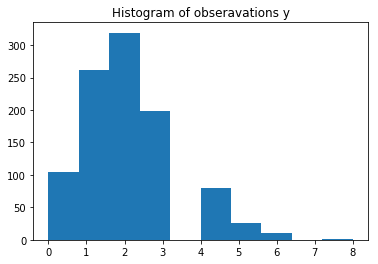

In [3]:
K_truth = 10
p = torch.Tensor([0.2])

# poisson prior parameter
prior_rate = torch.Tensor([K_truth])

# number of observations 
n_obs = 1000

binom = binomial.Binomial(total_count=K_truth, probs=p)

# draw data 
y = binom.sample([n_obs]).squeeze()

plt.title('Histogram of obseravations y')
plt.hist(y); 

# Inference

To infer $K$, we use a variational approximation. We propose a Negative Binomial for the variational distribution, 
so 

\begin{align}
    q(k) = \text{Neg. Binomial}(k; \hat r, \hat p)
\end{align}

And we optimize the ELBO, over $\hat r, \hat p$

\begin{align}
\mathcal{L}(\hat r, \hat p) = E_{q(K; \hat r, \hat p)}[\log p(y | K)p(K) - \log q(K; \hat r, \hat p)]
\end{align}

A minor note though ... we need to shift the Neg.Binomial by the max of the observations y -- we know with certainty that K > max(y). 

### log probabilities and log likelihoods

In [4]:
def _log_choose(n, k): 
    # this returns n choose k
    return torch.lgamma(n + 1.) - torch.lgamma(n - k + 1.) - torch.lgamma(k + 1.)

In [5]:
def get_log_poisson_prior(n, prior_rate):  
    # log likelihood of n under poisson with rate prior_rate
    return torch.log(prior_rate) * n - torch.lgamma(n + 1.)

In [6]:
def get_binomial_loglik(n, p, y): 
    # log likelihood of observation y, drawn binomial(n, p) 
    
    # log binomial coefficient 
    binom_coeff = _log_choose(n, y)
    # probabilities
    log_probs = y * torch.log(p) + (n - y) * torch.log(1 - p)

    return binom_coeff + log_probs

In [7]:
def get_neg_binom_logprob(n, nb_r, nb_p): 
    # negative log probability of observing n successes
    # before nb_r failues, and success probability nb_p
    return _log_choose(n + nb_r - 1, n) + torch.log(1 - nb_p) * nb_r + torch.log(nb_p) * n

### functions to get the loss

In [8]:
def sample_neg_binom(nb_r, nb_p, size): 
    # sample from a negative binomial 
    
    neg_binom = negative_binomial.NegativeBinomial(total_count = nb_r, probs = nb_p)
    return neg_binom.sample(size).squeeze()

In [9]:
def get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000): 
    # return negative elbo as a function of variational parameters 
    # nb_r, nb_logit_p (nb_r is \hat r, nb_logit_p is the logit of \hat p in our notation above)
    
    # y is a vector of observations
    assert len(y.size()) == 1
    n_obs = y.size()[0]
    
    nb_p = torch.sigmoid(nb_logit_p)
    
    # sample 
    neg_binom_samples = sample_neg_binom(nb_r, nb_p, [n_samples])
    
    _n = neg_binom_samples.view(-1, n_samples)
    _y = y.view(n_obs, -1)
        
    # joint log likelihood 
    loglik = (get_binomial_loglik(_n + torch.max(y), p, _y).sum() + \
                  get_log_poisson_prior(_n + torch.max(y), prior_rate).sum()) / n_samples
    
    # entropy term 
    log_probs = get_neg_binom_logprob(neg_binom_samples, nb_r, nb_p)
    entropy = -(log_probs * torch.exp(log_probs)).mean()
    
    return -loglik - entropy

In [19]:
def get_cond_loss(y, p, nb_r, nb_p, prior_rate, neg_binom_sample):
    # this is the loss conditional on a sample from the negative binomial 
    
    log_prob = get_neg_binom_logprob(neg_binom_sample, nb_r, nb_p)
    
    # loss 
    loglik = get_binomial_loglik(neg_binom_sample + torch.max(y), p, y).sum() + \
                    get_log_poisson_prior(neg_binom_sample + torch.max(y), prior_rate)
    entropy = -log_prob * torch.exp(log_prob)
    loss = -(loglik + entropy)
    
    return loss, log_prob

In [20]:
# The pseudo-loss: when we take the gradient, we get the REINFORCE estimator

In [21]:
def get_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, use_baseline = False):
    # when taking a gradient, this is the REINFORCE estimator
    
    nb_p = torch.sigmoid(nb_logit_p)
    
    neg_binom_sample = sample_neg_binom(nb_r, nb_p, [1]).detach()
    
    loss, log_prob = get_cond_loss(y, p, nb_r, nb_p, prior_rate, neg_binom_sample)
    
    # compute baseline 
    if use_baseline: 
        neg_binom_sample2 = sample_neg_binom(nb_r, nb_p, [1]).detach()
        baseline, _ = get_cond_loss(y, p, nb_r, nb_p, prior_rate, neg_binom_sample2)
    else: 
        baseline = 0.0
    
    return (loss - baseline).detach() * log_prob

In [22]:
use_baseline = True

# Optimize the ELBO using REINFORCE

In [23]:
nb_r = torch.Tensor([7.])
nb_logit_p = torch.Tensor([0.])

nb_r.requires_grad_(True); 
nb_logit_p.requires_grad_(True); 

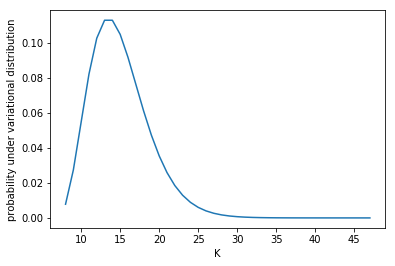

In [24]:
# our initial variational distribution
n_cat = 40
log_prob_vec = torch.zeros(n_cat)
for n in range(n_cat): 
    log_prob_vec[n] = get_neg_binom_logprob(torch.Tensor([n]), nb_r, torch.sigmoid(nb_logit_p))
plt.plot(np.arange(n_cat) + torch.max(y).numpy(), 
         torch.exp(log_prob_vec).detach().numpy())
plt.xlabel('K'); 
plt.ylabel('probability under variational distribution'); 

In [25]:
var_params = {'nb_r': nb_r, 'nb_logit_p': nb_logit_p}

In [26]:
params_list = [{'params': var_params[key]} for key in var_params]
optimizer = optim.SGD(params_list, lr = 1e-4)

In [27]:
n_steps = 100

loss_array = np.zeros(n_steps)

for i in range(n_steps):
    # run SGD
    optimizer.zero_grad()
    
    # compute gradient and step
    ps_loss = get_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, use_baseline = use_baseline)
    ps_loss.backward()
    optimizer.step()

    # save losses
    loss_array[i] = get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()


Text(0.5, 0, 'Iteration')

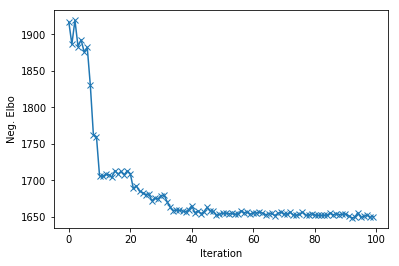

In [28]:
plt.plot(loss_array, '-x')
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

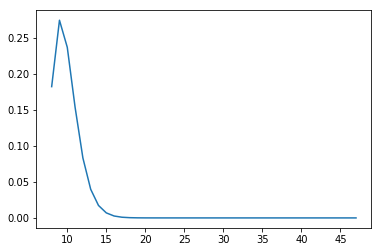

In [29]:
# our final variational distribution
n_cat = 40
log_prob_vec = torch.zeros(n_cat)
for n in range(n_cat): 
    log_prob_vec[n] = get_neg_binom_logprob(torch.Tensor([n]), nb_r, torch.sigmoid(nb_logit_p))
plt.plot(np.arange(n_cat) + torch.max(y).numpy(), 
         torch.exp(log_prob_vec).detach().numpy())


OK, lets look at average paths. 

In [30]:
n_trials = 10

reinforce_loss_array = np.zeros((n_trials, n_steps))

for k in range(n_trials): 
    # re-initialize
    nb_r = torch.Tensor([7.])
    nb_logit_p = torch.Tensor([0.])

    nb_r.requires_grad_(True); 
    nb_logit_p.requires_grad_(True);
    
    var_params = {'nb_r': nb_r, 'nb_logit_p': nb_logit_p}
    params_list = [{'params': var_params[key]} for key in var_params]
    optimizer = optim.SGD(params_list, lr = 1e-4)
    
    reinforce_loss_array[k, 0] = \
            get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()
        
    for i in range(1, n_steps):
        # run SGD
        optimizer.zero_grad()

        # compute gradient and step
        ps_loss = get_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, use_baseline = use_baseline)
        ps_loss.backward()
        optimizer.step()

        # save losses
        reinforce_loss_array[k, i] = \
            get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()

Text(0.5, 0, 'Iteration')

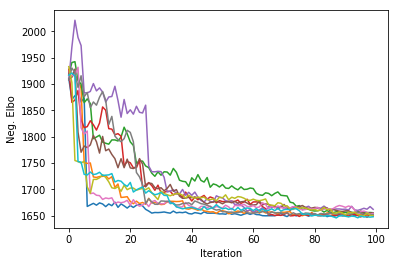

In [31]:
plt.plot(reinforce_loss_array.T);
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

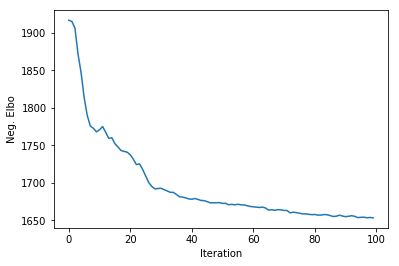

In [32]:
plt.plot(reinforce_loss_array.mean(axis = 0));
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

# Does Rao-Blackwellization help?

In [33]:
def sample_cond_neg_binom(nb_r, nb_p, exclude_cat): 
    # sample negative binomial conditional on 
    # not being in ``exclude_cat`` 
    
    neg_binom = negative_binomial.NegativeBinomial(total_count = nb_r, probs = nb_p)
    
    sample = exclude_cat
    while sample == exclude_cat: 
        sample = neg_binom.sample([1]).squeeze()
    
    return sample

In [69]:
def get_rb_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, 
                             use_baseline = False, 
                             k = 0):
    
    # this returns the loss for our Rao-blackwellized estimator. 
    # k refers to the radius of integers that we sum 
    # around the MAP category. So k = 0 is just summing out the MAP category. 
    # k = 1 sums out three categories: the MAP category, and the two integers above and below. 
    
    nb_p = torch.sigmoid(nb_logit_p)
    
    # Get MAP category 
    map_nb_sample = torch.floor(nb_p*(nb_r - 1) / (1 - nb_p))
    
    # Compute loss at MAP category 
    loss_map, log_prob_map = get_cond_loss(y, p, nb_r, nb_p, prior_rate, map_nb_sample)
    
    # compute baseline 
    if use_baseline: 
        nb_bs_sample = sample_neg_binom(nb_r, nb_p, [1]).detach()
        baseline, _ = get_cond_loss(y, p, nb_r, nb_p, prior_rate, nb_bs_sample)
    else: 
        baseline = 0.0
        
    # gradient estimate at map loss 
    summed_loss = (loss_map - baseline).detach() * log_prob_map
    summed_probs = torch.exp(log_prob_map)
    
    # if we want to sum other categories: 
    for i in range(1, k + 1): 
        # sum the categories around the map category
        loss_map1, log_prob_map1 = get_cond_loss(y, p, nb_r, nb_p, prior_rate, map_nb_sample + i * k)
        loss_map2, log_prob_map2 = get_cond_loss(y, p, nb_r, nb_p, prior_rate, map_nb_sample - i * k)

        if use_baseline: 
            nb_bs_sample1 = sample_neg_binom(nb_r, nb_p, [1]).detach()
            baseline1, _ = get_cond_loss(y, p, nb_r, nb_p, prior_rate, nb_bs_sample1)

            nb_bs_sample2 = sample_neg_binom(nb_r, nb_p, [1]).detach()
            baseline2, _ = get_cond_loss(y, p, nb_r, nb_p, prior_rate, nb_bs_sample2)

        summed_loss += (loss_map1 - baseline1).detach() * log_prob_map1 + \
                            (loss_map2 - baseline2).detach() * log_prob_map2
            
        summed_probs += torch.exp(log_prob_map2) + torch.exp(log_prob_map1)
        
    # Now sample from the rest 
    # and compute gradient estimator again 
    nb_sample_exclude = sample_cond_neg_binom(nb_r, nb_p, map_nb_sample)
    loss, log_prob = get_cond_loss(y, p, nb_r, nb_p, prior_rate, nb_sample_exclude)
    if use_baseline: 
        nb_bs_sample2 = sample_neg_binom(nb_r, nb_p, [1]).detach()
        baseline2, _ = get_cond_loss(y, p, nb_r, nb_p, prior_rate, nb_bs_sample2)
    else: 
        baseline2 = 0.0
        
    grad_sample_ps_loss = (loss - baseline2).detach() * log_prob
    
    return summed_loss + (1 - summed_probs).detach() * grad_sample_ps_loss

In [70]:
# initialize
nb_r = torch.Tensor([7.])
nb_logit_p = torch.Tensor([0.])

nb_r.requires_grad_(True); 
nb_logit_p.requires_grad_(True); 

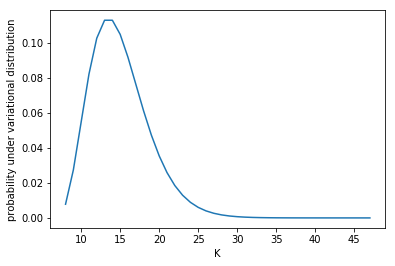

In [71]:
# our initial variational distribution
n_cat = 40
log_prob_vec = torch.zeros(n_cat)
for n in range(n_cat): 
    log_prob_vec[n] = get_neg_binom_logprob(torch.Tensor([n]), nb_r, torch.sigmoid(nb_logit_p))
plt.plot(np.arange(n_cat) + torch.max(y).numpy(), 
         torch.exp(log_prob_vec).detach().numpy())
plt.xlabel('K'); 
plt.ylabel('probability under variational distribution'); 

In [72]:
var_params = {'nb_r': nb_r, 'nb_logit_p': nb_logit_p}

In [73]:
params_list = [{'params': var_params[key]} for key in var_params]
optimizer = optim.SGD(params_list, lr = 1e-4)

### optimize summing out top category

In [74]:
n_steps = 100

loss_array = np.zeros(n_steps)

for i in range(n_steps):
    # run SGD
    optimizer.zero_grad()
    
    # compute gradient and step
    ps_loss = get_rb_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, 
                                       use_baseline = use_baseline)
    ps_loss.backward()
    optimizer.step()

    # save losses
    loss_array[i] = get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()


Text(0.5, 0, 'Iteration')

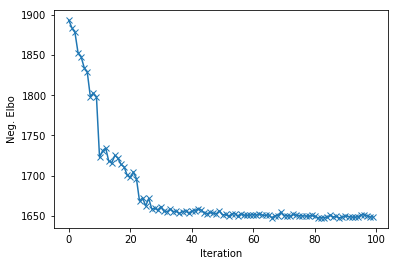

In [75]:
plt.plot(loss_array, '-x')
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

again, we should look at average paths ... 

In [41]:
rb_reinforce_loss_array = np.zeros((n_trials, n_steps))

for k in range(n_trials): 
    # re-initialize
    nb_r = torch.Tensor([7.])
    nb_logit_p = torch.Tensor([0.])

    nb_r.requires_grad_(True); 
    nb_logit_p.requires_grad_(True);
    
    var_params = {'nb_r': nb_r, 'nb_logit_p': nb_logit_p}
    params_list = [{'params': var_params[key]} for key in var_params]
    optimizer = optim.SGD(params_list, lr = 1e-4)

    rb_reinforce_loss_array[k, 0] = \
            get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()
        
    for i in range(1, n_steps):
        # run SGD
        optimizer.zero_grad()

        # compute gradient and step
        ps_loss = get_rb_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, 
                                           use_baseline = use_baseline)
        ps_loss.backward()
        optimizer.step()

        # save losses
        rb_reinforce_loss_array[k, i] = \
            get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()

Text(0.5, 0, 'Iteration')

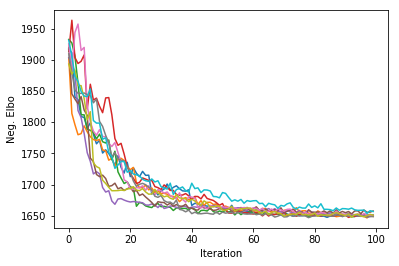

In [42]:
plt.plot(rb_reinforce_loss_array.T)
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

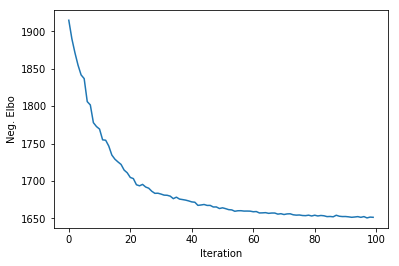

In [43]:
plt.plot(rb_reinforce_loss_array.mean(axis = 0))
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

# Sum out top 3 categories

In [76]:
rb3_reinforce_loss_array = np.zeros((n_trials, n_steps))

for k in range(n_trials): 
    # re-initialize
    nb_r = torch.Tensor([7.])
    nb_logit_p = torch.Tensor([0.])

    nb_r.requires_grad_(True); 
    nb_logit_p.requires_grad_(True);
    
    var_params = {'nb_r': nb_r, 'nb_logit_p': nb_logit_p}
    params_list = [{'params': var_params[key]} for key in var_params]
    optimizer = optim.SGD(params_list, lr = 1e-4)

    rb3_reinforce_loss_array[k, 0] = \
            get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()
        
    for i in range(1, n_steps):
        # run SGD
        optimizer.zero_grad()

        # compute gradient and step
        ps_loss = get_rb_reinforce_ps_loss(y, p, nb_r, nb_logit_p, prior_rate, 
                                           use_baseline = use_baseline, 
                                          k = 1)
        ps_loss.backward()
        optimizer.step()

        # save losses
        rb3_reinforce_loss_array[k, i] = \
            get_loss(y, p, nb_r, nb_logit_p, prior_rate, n_samples = 1000).detach().numpy()

Text(0.5, 0, 'Iteration')

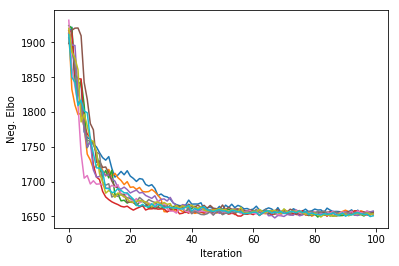

In [77]:
plt.plot(rb3_reinforce_loss_array.T)
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

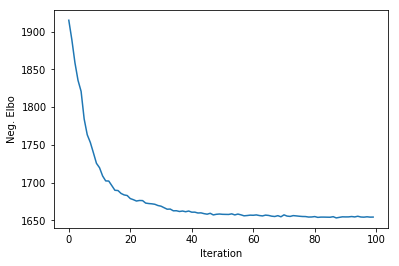

In [78]:
plt.plot(rb3_reinforce_loss_array.mean(axis = 0))
plt.ylabel('Neg. Elbo')
plt.xlabel('Iteration')

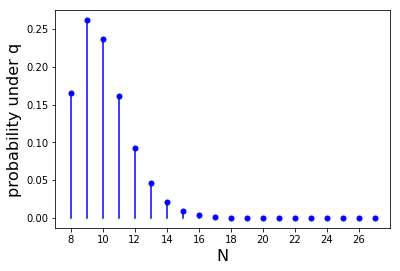

In [98]:
# our initial variational distribution
n_cat = 20
log_prob_vec = torch.zeros(n_cat)
for n in range(n_cat): 
    log_prob_vec[n] = get_neg_binom_logprob(torch.Tensor([n]), nb_r, torch.sigmoid(nb_logit_p))

points = [(i + y.max(), torch.exp(log_prob_vec[i])) for i in range(n_cat)] 

for pt in points:
    # plot (x,y) pairs.
    # vertical line: 2 x,y pairs: (a,0) and (a,b)
    plt.plot([pt[0],pt[0]], [0,pt[1]], color = 'blue')

plt.plot(np.arange(n_cat) + torch.max(y).numpy(), 
         torch.exp(log_prob_vec).detach().numpy(), 
         'o', markersize = 5, color = 'blue')

plt.xlabel('N', fontsize = 16); 
plt.ylabel('probability under q', fontsize = 16); 

plt.xticks(np.arange(y.max(), y.max() + n_cat, step=2));

plt.savefig('../icml_figures/nmixture_q.png')

In [82]:
points

[(tensor(8.), tensor(-1.8008, grad_fn=<SelectBackward>)),
 (tensor(9.), tensor(-1.3411, grad_fn=<SelectBackward>)),
 (tensor(10.), tensor(-1.4383, grad_fn=<SelectBackward>)),
 (tensor(11.), tensor(-1.8211, grad_fn=<SelectBackward>)),
 (tensor(12.), tensor(-2.3846, grad_fn=<SelectBackward>)),
 (tensor(13.), tensor(-3.0746, grad_fn=<SelectBackward>)),
 (tensor(14.), tensor(-3.8587, grad_fn=<SelectBackward>)),
 (tensor(15.), tensor(-4.7160, grad_fn=<SelectBackward>)),
 (tensor(16.), tensor(-5.6320, grad_fn=<SelectBackward>)),
 (tensor(17.), tensor(-6.5960, grad_fn=<SelectBackward>)),
 (tensor(18.), tensor(-7.6002, grad_fn=<SelectBackward>)),
 (tensor(19.), tensor(-8.6386, grad_fn=<SelectBackward>)),
 (tensor(20.), tensor(-9.7064, grad_fn=<SelectBackward>)),
 (tensor(21.), tensor(-10.7997, grad_fn=<SelectBackward>)),
 (tensor(22.), tensor(-11.9154, grad_fn=<SelectBackward>)),
 (tensor(23.), tensor(-13.0509, grad_fn=<SelectBackward>)),
 (tensor(24.), tensor(-14.2042, grad_fn=<SelectBackward

# Compare 

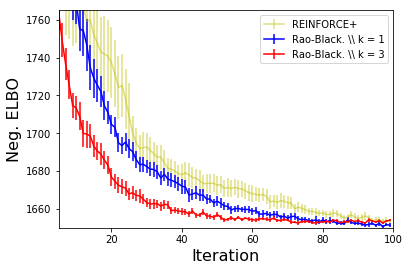

In [53]:
plt.errorbar(np.arange(n_steps), 
            np.mean(reinforce_loss_array, axis = 0), 
            yerr= np.std(reinforce_loss_array, axis = 0) / np.sqrt(n_trials), 
            label = 'REINFORCE+', 
            color = 'y', alpha = 0.5)

plt.errorbar(np.arange(n_steps), 
            np.mean(rb_reinforce_loss_array, axis = 0), 
            yerr= np.std(rb_reinforce_loss_array, axis = 0) / np.sqrt(n_trials), 
            label = 'Rao-Black. \\\\ k = 1', 
            color = 'b')

plt.errorbar(np.arange(n_steps), 
            np.mean(rb3_reinforce_loss_array, axis = 0), 
            yerr= np.std(rb3_reinforce_loss_array, axis = 0) / np.sqrt(n_trials), 
            label = 'Rao-Black. \\\\ k = 3', 
            color = 'r')


plt.legend()


plt.ylim((1650, 1765))
plt.xlim((5, 100))

plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Neg. ELBO', fontsize = 16)

plt.savefig('../icml_figures/nmixture_elbo_path.png')